In [19]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F


from monai.transforms import ScaleIntensity
from monai.config import print_config

from scripts.train import LitUnet, CentreDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import seed_everything

seed_everything(42, workers=True)

from scripts.utils import *

#print_config()


def display_subplot(data, title, ax, cmap="gray"):
    ax.imshow(data, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

def predict_and_display_examples(model, n, loader, centre):
    seed_everything(42, workers=True)

    it = iter(loader)
    batch = next(it)
    batch = next(it)
    batch = next(it)

    x, y = batch

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = x.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(x)
    prob = F.softmax(pred, dim=1)
    y_pred = torch.argmax(prob, dim=1).cpu()

    fig, axes = plt.subplots(3, 1, figsize=(n, 5))
    fig.suptitle(f"Image Predictions and Ground Truth for center {centre}", fontsize=16)
    
    display_subplot(rearrange(x.cpu()[:n+1], "b c h w -> h (b w) c"), "Images", axes[0])
    display_subplot(rearrange(y_pred[:n+1], "b h w -> h (b w)"), "Predictions", axes[1], cmap="viridis")
    display_subplot(rearrange(y[:n+1], "b h w -> h (b w)"), "Ground Truth", axes[2], cmap="viridis")

    plt.tight_layout()
    plt.show()

Global seed set to 42


In [2]:
model = LitUnet(lr=1e-3)

transform =  ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)
dm = CentreDataModule("A", train_centre=6, load_transform=transform, batch_size=8)
# Training and Validation
trainer = pl.Trainer(max_epochs=50, 
                     deterministic=True, 
                     logger=True,
                     log_every_n_steps=1, 
                     enable_model_summary=False,
                     callbacks=[EarlyStopping('val_loss', patience=3)], 
                     fast_dev_run=False)
trainer.fit(model, datamodule=dm)
trainer.save_checkpoint("checkpoints/benchmark_deterministic.ckpt")

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(


total number of samples: 95, train samples: 66, Validation: 29


100%|██████████| 29/29 [00:00<00:00, 38.99it/s]
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/ids/mahdi-22/M-M/lightning_logs/version_39011/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 11: 100%|██████████| 195/195 [00:06<00:00, 28.90it/s, v_num=39011, val_loss=0.0701, train_loss=0.0393]


In [21]:
trainer.logged_metrics

{'val_loss': metatensor(0.0701, dtype=torch.float64),
 'train_loss': metatensor(0.0393, dtype=torch.float64)}

Global seed set to 42


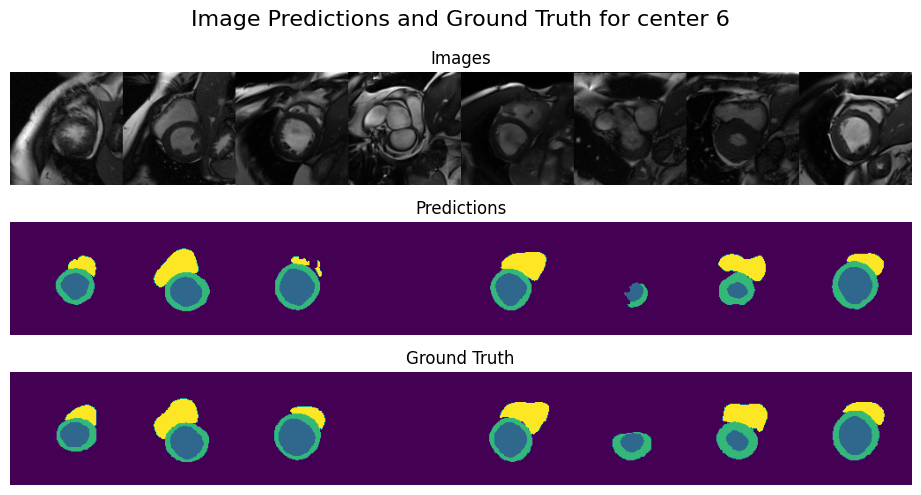

Global seed set to 42


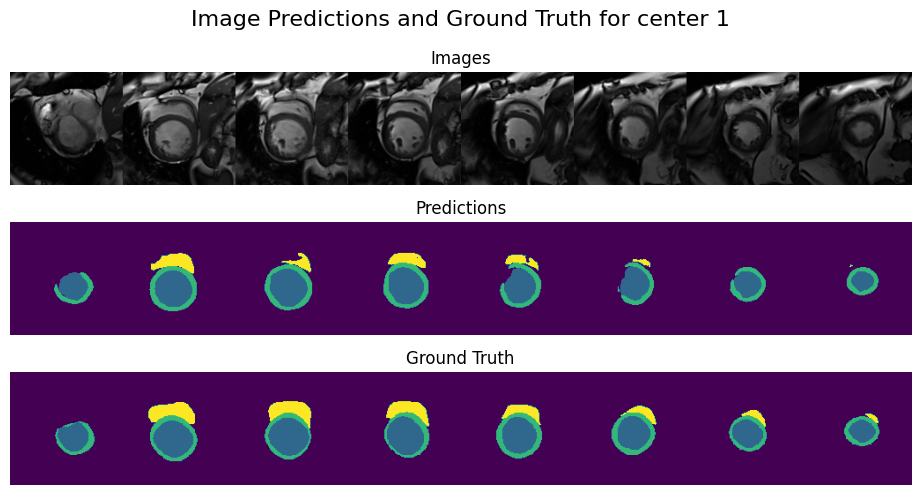

In [20]:
model = LitUnet.load_from_checkpoint("checkpoints/benchmark_deterministic.ckpt")
n_max = 20

train_dataloader = dm.train_dataloader()
train_dataloader.shuffle = False
predict_and_display_examples(model, n_max, train_dataloader, 6)

val_dataloader = dm.val_dataloader()
predict_and_display_examples(model, n_max, val_dataloader, 1)